In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
directory = '/Users/esens/Python/SearchNBlogWithoutAds_Crawler'
train_dir = directory+'/train'
validation_dir = directory+'/validation'

train_image_dir = os.path.join(train_dir, 'image')  
train_advertise_dir = os.path.join(train_dir, 'advertise')  

validation_image_dir = os.path.join(validation_dir, 'image')
validation_advertise_dir = os.path.join(validation_dir, 'advertise')


In [3]:

num_image_tr = len(os.listdir(train_image_dir))
num_advertise_tr = len(os.listdir(train_advertise_dir))

num_image_val = len(os.listdir(validation_image_dir))
num_advertise_val = len(os.listdir(validation_advertise_dir))

total_train = num_image_tr + num_advertise_tr
total_val = num_image_val + num_advertise_val

In [4]:
print('total training image images:', num_image_tr)
print('total training advertise images:', num_advertise_tr)
print('num_image_tr : ' , num_image_tr);

print('total validation image images:', num_image_val)
print('total validation advertise images:', num_advertise_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training image images: 8
total training advertise images: 8
num_image_tr :  8
total validation image images: 5
total validation advertise images: 5
--
Total training images: 16
Total validation images: 10


In [5]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [6]:
#for training data 
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 14 images belonging to 2 classes.


In [7]:
#for validation data 
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 8 images belonging to 2 classes.


In [8]:
sample_training_images, _ = next(train_data_gen)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# plotImages(sample_training_images[:5])
# create the model
def create_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [11]:
model = create_model();
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [12]:
# 모델 저장
checkpoint_path = "trained_advertise_0615/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 15번째 에포크에서 저장
    period=15)


In [13]:
checkpoint_path

'trained_advertise_0615/cp-{epoch:04d}.ckpt'

In [14]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    callbacks =[cp_callback],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/15
1/1 [==============================] - 1s 705ms/step - loss: 0.6991 - accuracy: 0.5000 - val_loss: 1.6410 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 277ms/step - loss: 1.2786 - accuracy: 0.5000 - val_loss: 1.7611 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 287ms/step - loss: 1.3659 - accuracy: 0.6429 - val_loss: 0.9644 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 302ms/step - loss: 0.6838 - accuracy: 0.6429 - val_loss: 0.5747 - val_accuracy: 0.8750
Epoch 5/15
1/1 [==============================] - 0s 275ms/step - loss: 0.3823 - accuracy: 1.0000 - val_loss: 0.5605 - val_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 0s 292ms/step - loss: 0.3513 - accuracy: 0.7143 - val_loss: 0.4670 - val_accuracy: 0

checkpoint                       cp-0015.ckpt.index
cp-0015.ckpt.data-00000-of-00001


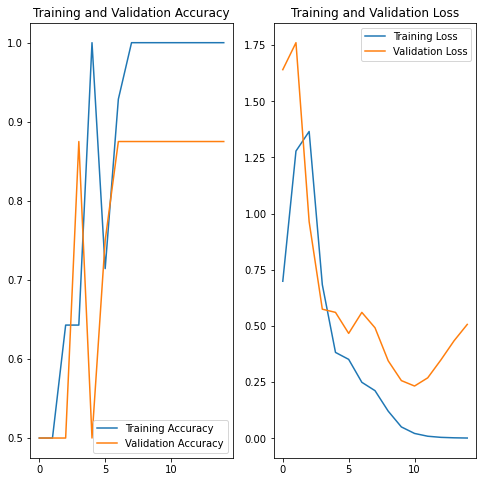

In [15]:
! ls {checkpoint_dir}
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
PATH =directory + "/test"

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=str(PATH),
                                                batch_size=batch_size,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
print("test_data_gen : " , test_data_gen)
print(test_data_gen.labels)

Found 8 images belonging to 2 classes.
test_data_gen :  <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x1087e76d8>
[0 0 0 0 1 1 1 1]


In [19]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# create model
model = create_model()
model.load_weights(latest)

trained_advertise_0615/cp-0015.ckpt


In [20]:
my_img_path = directory + "/test/i/4.jpg"
image = tf.keras.preprocessing.image.load_img(my_img_path,target_size=(150, 150))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

#print("model shape : " , model.summary());
# print("input_arr : ", input_arr)

predictions_class = model.predict_classes(input_arr)
predictions = model.predict(input_arr)

print("========pridiction========")
print(test_data_gen.class_indices)
print("predictions class : " , predictions_class);
#print("predictions argmax : ",np.argmax(predictions[0])); # same way


========pridiction========
{'advertise': 0, 'image': 1}
predictions class :  [[1]]
